In [ ]:
# !pip install deepxde
# !python -m deepxde.backend.set_default_backend pytorch

In [ ]:
# libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
# import deepxde as dde
import os
from random import random, randint
import math

# os.environ["DDE_BACKEND"] = "pytorch"
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
print(device)

cuda


In [ ]:
# data
def read_bin(file="test_u.bin"):

    f = open(file, "r")
    in_u = np.fromfile(f, dtype=np.int32)
    # f = open("test_v.bin", "r")
    # in_v = np.fromfile(f, dtype=np.int32)
    # f = open("test_w.bin", "r")
    # in_w = np.fromfile(f, dtype=np.int32)

    Nx = 4096
    Ny = 32
    Nz = 32
    slice_pts = Ny*Nz

    data_u = np.zeros((Nx, Ny, Nz))
    # data_v = np.zeros((Nx, Ny, Nz))
    # data_w = np.zeros((Nx, Ny, Nz))

    for i in range(int(np.size(in_u)/(slice_pts))):
        data_u[i,:,:] = np.reshape(in_u[i*slice_pts:(i+1)*slice_pts], (Ny, Nz))
        # data_v[i,:,:] = np.reshape(in_v[i*slice_pts:(i+1)*slice_pts], (Ny, Nz))
        # data_w[i,:,:] = np.reshape(in_w[i*slice_pts:(i+1)*slice_pts], (Ny, Nz))

    # return data_u, data_v, data_w
    return data_u

def gen_data(num_files = 5, train_perc = 0.9):

    data_u = read_bin("test1_u.bin")
    data_u = data_u.astype(np.single)

    mean = np.mean(data_u)
    std = np.std(data_u)
    data_u = (data_u - mean)/std

    num_train = math.floor(train_perc*np.shape(data_u)[0])

    u_in_train = data_u[0:num_train, :, :]
    u_out_train = data_u[1:(num_train+1), :, :]
    u_in_test = data_u[num_train:-1, :, :]
    u_out_test = data_u[(num_train+1):, :, :]

    for i in range(2,num_files+1):
        data = read_bin(f"test{i}_u.bin")
        data = data.astype(np.single)

        mean = np.mean(data)
        std = np.std(data)
        data = (data - mean)/std

        u_in_train = np.concatenate((u_in_train, data[0:num_train, :, :]), axis=0)
        u_out_train = np.concatenate((u_out_train, data[1:(num_train+1), :, :]), axis=0)
        u_in_test = np.concatenate((u_in_test, data[num_train:-1, :, :]), axis=0)
        u_out_test = np.concatenate((u_out_test, data[(num_train+1):, :, :]), axis=0)

    Nx, Ny, Nz = np.shape(data_u)[0], 32, 32

    x = np.linspace(0, 1000, Nx)
    y = np.linspace(-1, 1, Ny, dtype=np.single)
    z = np.linspace(-1, 1, Nz, dtype=np.single)
    y = torch.from_numpy(np.reshape(y, (32,1)))
    z = torch.from_numpy(np.reshape(z, (32,1)))

    u_in_train = torch.from_numpy(np.reshape(u_in_train, (np.shape(u_in_train)[0], 1, 32, 32)))
    u_in_test = torch.from_numpy(np.reshape(u_in_test, (np.shape(u_in_test)[0], 1, 32, 32)))
    u_out_train = torch.from_numpy(np.reshape(u_out_train, (np.shape(u_out_train)[0], Ny*Nz)))
    u_out_test = torch.from_numpy(np.reshape(u_out_test, (np.shape(u_out_test)[0], Ny*Nz)))

    u_in_train = u_in_train.to(device)
    u_in_test = u_in_test.to(device)
    u_out_train = u_out_train.to(device)
    u_out_test = u_out_test.to(device)
    y = y.to(device)
    z = z.to(device)
    
    return u_in_train, u_in_test, u_out_train, u_out_test, y, z


In [ ]:
# setup cnn
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # need to adjust
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 3)        
        self.linear = torch.nn.Sequential(
                        torch.nn.Linear(64, 400),
                        torch.nn.ReLU(),
                        torch.nn.Linear(400, 1024)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        #flatten
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = self.linear(x)
        return x

# setup fnn for trunk network
# FNN class
class FNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Sequential(
                torch.nn.Linear(2, 200),
                torch.nn.Tanh(),
                torch.nn.Linear(200, 600),
                torch.nn.Tanh(),
                torch.nn.Linear(600,1024)
                )

    def forward(self, y, z):
        # run through network
        x = torch.cartesian_prod(y.flatten(),z.flatten())
        x = self.linear1(x)
        return x

In [ ]:
# PI-DeepONET class
class wind_deepONet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = ConvNN()
        self.trunk = FNN()

    def forward(self, u, y, z):
        # call branch net
        B = self.branch(u)
        # call trunk net
        T = self.trunk(y, z)
        # inner product
        out = torch.mm(B, T)
        return out


In [ ]:
# data loss is MSE
def data_loss(u_pred, u_target):
    # print(np.size(u_pred.detach().cpu().numpy()))
    out = torch.sum((u_pred - u_target)**2) / np.size(u_pred.detach().cpu().numpy())
    # print(out)
    return out

def pde_res(net, u_in, y, z):
    y.requires_grad_()
    z.requires_grad_()
    u_in = torch.reshape(u_in, (1, 1, 32, 32))
    u = net(u_in, y, z)
    # print(np.shape(u))
    batch_res = torch.zeros((np.shape(u_in)[0], 1))
    sum = 0
    count = 1
    for i in range(np.shape(u)[1]):
        if random() < 0.01: #sample 10% of the points to calculate grad for
            count = count + 1
      
            y_i = randint(0,31)
            z_i = randint(0,31)
            u_i = y_i*32 + z_i
  
            # just at corresponding y,z coord:
            '''
            u_y = torch.autograd.grad(outputs=u[0, u_i], inputs=y, create_graph=True)[0]
            u_yy = torch.autograd.grad(outputs=u_y[y_i], inputs=y, retain_graph=True)[0]
            u_z = torch.autograd.grad(outputs=u[0, u_i], inputs=z, create_graph=True)[0]
            u_zz = torch.autograd.grad(outputs=u_z[z_i], inputs=z, retain_graph=True)[0]

            R = u_yy[y_i] + u_zz[z_i]
            sum = sum + R 
            '''
            # whole hessians:
            
            u_y = torch.autograd.grad(outputs=u[0, u_i], inputs=y, create_graph=True)[0]
            u_z = torch.autograd.grad(outputs=u[0, u_i], inputs=z, create_graph=True)[0]
            hess_yy = torch.zeros((32, 32))
            hess_zz = torch.zeros((32, 32))
            for j in range(32):
                hess_yy[j,:] = torch.autograd.grad(outputs=u_y[j], inputs=y, retain_graph=True)[0].flatten()
                hess_zz[j,:] = torch.autograd.grad(outputs=u_z[j], inputs=z, retain_graph=True)[0].flatten()
            # the hessians are diagonal matrices
            R = torch.diagonal(hess_yy) + torch.diagonal(hess_zz)
            # determinant of diagonal matrix is product of elements along the diagonal
            res = torch.prod(R)**2
            sum = sum + res
            
            # print('got here')
    return sum / (count * 32)

def pde_loss(net, u_in, y, z):
    batches = np.shape(u_in)[0]
    out = 0
    for i in range(batches):
        out = out + pde_res(net, u_in[i,:], y, z)
    print(out)
    return out / batches


class total_loss(torch.nn.Module):
    def __init__(self, weights = [1,1]):
        super().__init__()
        self.weights = weights

    def forward(self, u_pred, u_target, u_in, y, z, net):
        d_loss = self.weights[0] * data_loss(u_pred, u_target)
        p_loss = 0
        p_loss = self.weights[1] * pde_loss(net, u_in, y, z)
        out = d_loss + p_loss
        return out

In [ ]:
def train(net, n_iter=1000, batch_size=2000):
      # setup network
      Net = net
      Net.to(device)

      optimizer = torch.optim.Adam(Net.parameters(), lr = 0.001)
      loss_function = total_loss()

      loss_log = []

      n_batches = np.shape(u_in_train)[0] // batch_size
      # train network
      for it in range(n_iter):
          batch_losses = []
          for j in range(n_batches):
              u_in = u_in_train[j*batch_size:(j+1)*batch_size,:,:,:]
              u_out = u_out_train[j*batch_size:(j+1)*batch_size,:]

              u_pred = Net(u_in, y, z)

              loss = loss_function(u_pred, u_out, u_in, y, z, Net)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              batch_losses.append(loss.detach().cpu().numpy())
          loss_log.append(np.mean(batch_losses))
          if it % 10 == 0:
              print(f"\r Epoch: {it+1}/{n_iter}, Loss: {loss_log[it]}")

      return Net, loss_log

 Epoch: 1/10000, Loss: 1.4290862083435059
 Epoch: 11/10000, Loss: 0.6129060983657837
 Epoch: 21/10000, Loss: 0.5732280611991882
 Epoch: 31/10000, Loss: 0.5419436097145081
 Epoch: 41/10000, Loss: 0.5263365507125854
 Epoch: 51/10000, Loss: 0.5145204067230225
 Epoch: 61/10000, Loss: 0.5079026222229004
 Epoch: 71/10000, Loss: 0.503641664981842
 Epoch: 81/10000, Loss: 0.504571259021759
 Epoch: 91/10000, Loss: 0.5055012106895447
 Epoch: 101/10000, Loss: 0.5016637444496155
 Epoch: 111/10000, Loss: 0.49918121099472046
 Epoch: 121/10000, Loss: 0.48686477541923523
 Epoch: 131/10000, Loss: 0.4863222539424896
 Epoch: 141/10000, Loss: 0.48569440841674805
 Epoch: 151/10000, Loss: 0.4821391701698303
 Epoch: 161/10000, Loss: 0.4787496030330658
 Epoch: 171/10000, Loss: 0.4793010950088501
 Epoch: 181/10000, Loss: 0.4762475788593292
 Epoch: 191/10000, Loss: 0.4700891673564911
 Epoch: 201/10000, Loss: 0.46530166268348694
 Epoch: 211/10000, Loss: 0.4660106301307678
 Epoch: 221/10000, Loss: 0.46268284320831

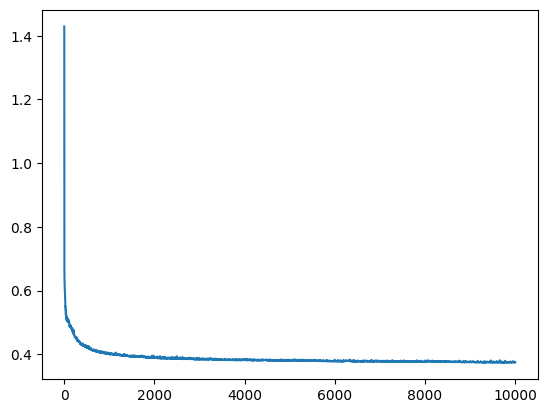

In [ ]:
# get data
u_in_train, u_in_test, u_out_train, u_out_test, y, z= gen_data(num_files=20)

# init model
model = wind_deepONet()

# train model
model, loss_log = train(model, n_iter=10000)

# plot loss
plt.plot(range(len(loss_log)), loss_log)

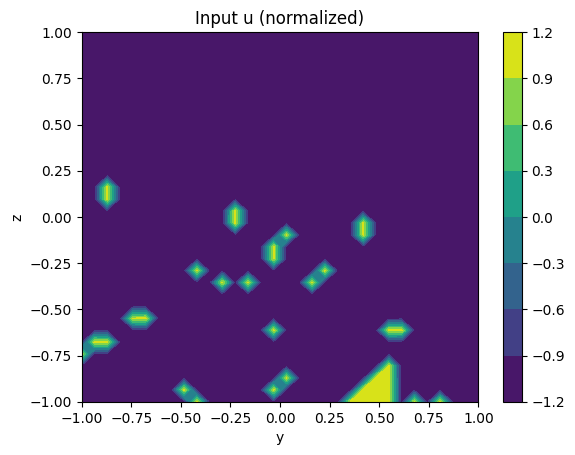

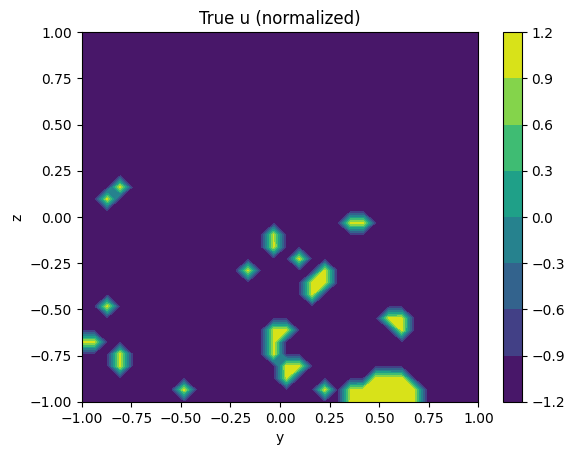

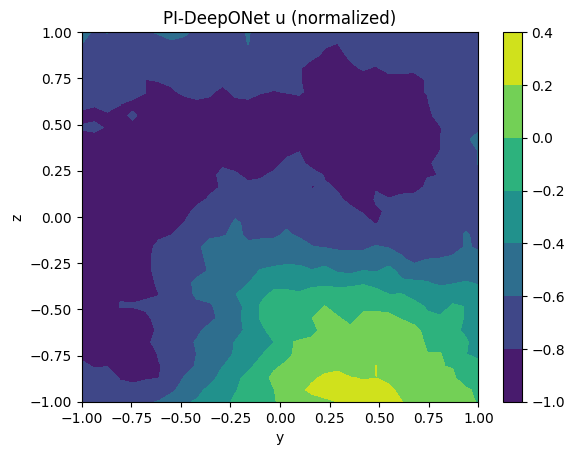

In [ ]:
# print velocity fields
def plot_vfield(u, title='u'):
    Ny = 32
    Nz = 32

    # plot for visualization
    y = np.linspace(-1, 1, Ny)
    z = np.linspace(-1, 1, Nz)
    Y, Z = np.meshgrid(y, z)

    fig, ax1 = plt.subplots(1,1)

    # fig1, = plt.subplot(1, 3, 1)
    c = ax1.contourf(Y, Z, u)
    # fig1.colorbar(cp1)  # Add a colorbar to a plot
    ax1.set_title(title)
    plt.xlabel('y')
    plt.ylabel('z')
    
    cbar = fig.colorbar(c)

# predict model
with torch.no_grad():
    u_pred = model(u_in_test, y, z).data

index = 401
plot_vfield(torch.reshape(u_out_train.cpu(), (np.shape(u_out_train)[0], 32, 32))[index-1], title='Input u (normalized)')
plot_vfield(torch.reshape(u_out_train.cpu(), (np.shape(u_out_train)[0], 32, 32))[index], title='True u (normalized)')
plot_vfield(torch.reshape(u_pred.cpu(), (np.shape(u_pred)[0], 32, 32))[index], title='PI-DeepONet u (normalized)')


In [ ]:
import deepxde as dde

error= dde.metrics.l2_relative_error(u_out_test.cpu(), u_pred.cpu())
print(f"L2 relative error {error}")


L2 relative error 0.2554719150066376
